In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = sns.load_dataset("mpg")

X_train, y_train = df[~df["horsepower"].isna()][["displacement", "acceleration"]], df[~df["horsepower"].isna()]["horsepower"]
X_pred = df[df["horsepower"].isna()][["displacement", "acceleration"]]

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_pred)
y_pred = np.round(y_pred)
df.loc[X_pred.index, "horsepower"] = y_pred
df = pd.get_dummies(df.drop("name", axis = 1), columns = ["origin"])
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_europe,origin_japan,origin_usa
0,18.0,8,307.0,130.0,3504,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449,10.5,70,0,0,1


In [3]:
X, y = df.drop(["mpg"], axis = 1).values, df["mpg"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [4]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

In [ ]:
%load_ext line_profiler


In [60]:
%reload_ext line_profiler
class ERegressor:
    def __init__(self, n = 100, hidden_layers = False, activation = "sigmoid", random_state = None):

        self.n = n // 2 * 2
        self.nets = []
        self.best_net = -1
        self.best_result = None
        self.validation_loss_history = []
        self.training_loss_history = []
        self.mutation_sigma = 0

        if activation == "sigmoid":
            #self.activation_function = np.vectorize(lambda x: 1 / (1 + math.exp(-x)))
            self.activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif activation == "relu":
            self.activation_function = lambda x: np.maximum(0, x)
        
        if hidden_layers:
            self.layers = hidden_layers + [1]
        else:
            self.layers = [1]
        
        if random_state != None:
            np.random.seed(random_state)

    
    def fit(self, X_train, y_train, epochs = 100, validation_data = False, verbose = 0):
        X_train = np.c_[np.ones(X_train.shape[0]), X_train]

        if validation_data:
            X_val, y_val = validation_data
        
        self.layers = [X_train.shape[1]] + self.layers

        for i in range(self.n):
            self.nets += [[]]
            for j in range(len(self.layers) - 1):
                self.nets[i] += [np.random.uniform(-3, 3, (self.layers[j], self.layers[j + 1]))]

        self.y_preds = np.zeros((len(self.nets), y_train.shape[0]))
        self.nets_loss = np.zeros(len(self.nets))
        self.sorted_indecies = np.zeros(len(self.nets))

        for epoch in range(epochs):
            for i in range(len(self.nets)):
                forward_pass = X_train.T

                for j in range(0, len(self.layers) - 2):
                    #forward_pass = self.activation_function(self.nets[i][j].T @ forward_pass)
                    #forward_pass = 1 / (1 + np.exp(-(self.nets[i][j].T @ forward_pass)))
                    forward_pass = np.maximum(0, (self.nets[i][j].T @ forward_pass))

                forward_pass = self.nets[i][-1].T @ forward_pass

                self.y_preds[i] = forward_pass.reshape(-1)
            
            self.test = y_train - self.y_preds
            self.nets_loss = np.mean(np.abs(self.y_preds - y_train), axis = 1)
            
            self.sorted_indecies = np.argsort(regressor.nets_loss)
            
            self.mutation_sigma = 0.1 + 5 * 1 / math.exp(epoch / (epochs / (10 * math.log10(epochs))))
            
            for i in range(0, self.n // 2, 2):
                for j in range(len(self.layers) - 1):
                    self.nets[self.sorted_indecies[self.n // 2 + i]][j] = (self.nets[self.sorted_indecies[i]][j] + self.nets[self.sorted_indecies[1 + i]][j]) / 2 + np.random.normal(0, self.mutation_sigma, (self.layers[j], self.layers[j + 1]))
                    self.nets[self.sorted_indecies[self.n // 2 + 1 + i]][j] = (self.nets[self.sorted_indecies[i]][j] + self.nets[self.sorted_indecies[1 + i]][j]) / 2 + np.random.normal(0, self.mutation_sigma, (self.layers[j], self.layers[j + 1]))

            if self.best_net != self.sorted_indecies[0]:
                self.best_net = self.sorted_indecies[0]
                self.training_loss_history += [self.nets_loss[self.best_net]]

                if validation_data:
                    self.validation_loss_history += [mean_absolute_error(y_val, self.predict(X_val))]
                    if verbose == 1:
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]} - val_loss: {self.validation_loss_history[-1]}")
                else:
                    if verbose == 1:
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]}")


    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]

        forward_pass = X.T
        for j in range(0, len(self.layers) - 2):
            forward_pass = self.activation_function(self.nets[self.best_net][j].T @ forward_pass)

        forward_pass = self.nets[self.best_net][-1].T @ forward_pass

        return forward_pass.reshape(-1)
        
regressor = ERegressor(n = 100, hidden_layers = [16, 16, 16], activation = "relu", random_state = 42)
#regressor.fit(scaled_X_train, y_train, epochs = 100, validation_data = (scaled_X_val, y_val), verbose = 1)

%lprun -f regressor.fit regressor.fit(scaled_X_train, y_train, epochs = 1000, validation_data = (scaled_X_val, y_val), verbose = 1)

Epoch 0 - loss: 86.80315411771315 - val_loss: 85.92074829122775
Epoch 52 - loss: 48.529593658799364 - val_loss: 37.92957627771934
Epoch 57 - loss: 46.16809098692537 - val_loss: 43.64601834537365
Epoch 61 - loss: 37.3078808650963 - val_loss: 43.2594308856887
Epoch 62 - loss: 24.374492409724166 - val_loss: 22.50102748409874
Epoch 64 - loss: 24.180719007757904 - val_loss: 28.8056701432513
Epoch 65 - loss: 21.465531030081713 - val_loss: 27.533882300689108
Epoch 67 - loss: 18.667022843275195 - val_loss: 14.55088036528893
Epoch 69 - loss: 15.348983235566964 - val_loss: 14.005709298107476
Epoch 72 - loss: 13.672580233853704 - val_loss: 16.69099270184025
Epoch 73 - loss: 13.46701468086422 - val_loss: 14.523411262108272
Epoch 76 - loss: 12.406823812751375 - val_loss: 13.043480970327625
Epoch 80 - loss: 10.727750323068534 - val_loss: 10.37402824278321
Epoch 85 - loss: 10.580806571953136 - val_loss: 9.454668235858986
Epoch 86 - loss: 9.319042955912032 - val_loss: 9.35616942541465
Epoch 91 - loss:

Timer unit: 1e-06 s

Total time: 5.24456 s
File: /var/folders/xz/f2gwbn5n3vs4pz044n49z3cw0000gn/T/ipykernel_97253/3792550349.py
Function: fit at line 28

Line #      Hits         Time  Per Hit   % Time  Line Contents
    28                                               def fit(self, X_train, y_train, epochs = 100, validation_data = False, verbose = 0):
    29         1         99.0     99.0      0.0          X_train = np.c_[np.ones(X_train.shape[0]), X_train]
    30                                           
    31         1          1.0      1.0      0.0          if validation_data:
    32         1          1.0      1.0      0.0              X_val, y_val = validation_data
    33                                                   
    34         1          1.0      1.0      0.0          self.layers = [X_train.shape[1]] + self.layers
    35                                           
    36       101         35.0      0.3      0.0          for i in range(self.n):
    37       100        

In [53]:
np.mean(regressor.test, axis = 0)

array([20.38907808, 27.40096933, 38.22823466, 36.39181638, 24.67730235,
       19.19756314, 34.45134532, 33.44129524, 21.23348381, 17.5762968 ,
       19.99514027, 23.098856  , 26.08849498, 38.93722181, 19.32271763,
       40.59873279, 31.57602559, 24.06227958, 29.25335776, 18.80163188,
       37.69902226, 22.23814778, 20.57754002, 21.35357074, 20.76608974,
       19.20174384, 30.77163694, 18.57135058, 35.3205911 , 38.435405  ,
       34.30007285, 29.79981516, 23.98802951, 32.59205133, 29.08561504,
       21.47165532, 29.11661789, 23.32646117, 39.56458541, 18.38459341,
       20.37645257, 22.92599093, 23.82833175, 23.10993197, 23.78347165,
       25.6312341 , 34.5173398 , 29.63963419, 39.00109399, 33.10990631,
       39.35769109, 33.5781582 , 42.13792762, 21.74119642, 21.61103486,
       24.66470606, 20.32280888, 35.58398435, 32.07925002, 33.81352409,
       22.34234932, 19.28604595, 20.3722272 , 18.55651073, 25.20357646,
       32.59249667, 28.00596188, 17.41155408, 25.97512463, 24.46

In [504]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
hi


Timer unit: 1e-06 s

Total time: 2.2e-05 s
File: /var/folders/xz/f2gwbn5n3vs4pz044n49z3cw0000gn/T/ipykernel_79586/3696412895.py
Function: func at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def func():
     4        11          3.0      0.3     13.6      for i in range(10):
     5        10          9.0      0.9     40.9          i ** i
     6         1         10.0     10.0     45.5      print("hi")

In [506]:
%reload_ext line_profiler


%lprun -f func func()

hi


Timer unit: 1e-06 s

Total time: 0.000111 s
File: /var/folders/xz/f2gwbn5n3vs4pz044n49z3cw0000gn/T/ipykernel_79586/2797496209.py
Function: func at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def func():
     4         1          1.0      1.0      0.9      a = 0
     5        11          3.0      0.3      2.7      for i in range(10):
     6        10          7.0      0.7      6.3          a *= i ** i
     7         1        100.0    100.0     90.1      print("hi")

In [497]:
y_pred = regressor.predict(scaled_X_test)

In [498]:
mean_absolute_error(y_test, y_pred)

1.9816996383925645

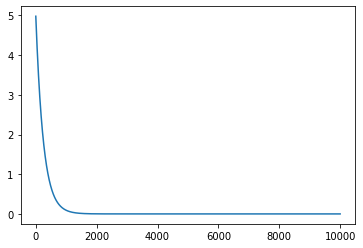

In [474]:
y = []
xrange = 10000

for x in range(1, xrange + 1):
    y.append(5 * 1 / math.exp(x / (xrange / (10 * math.log10(xrange)))))

plt.plot(list(range(xrange)), y)

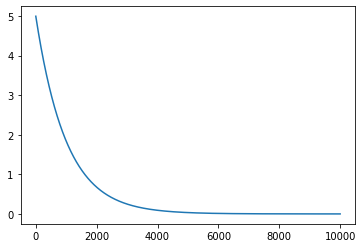

In [464]:
y = []
xrange = 10000

for x in range(1, xrange + 1):
    y.append(5 * 1 / math.exp(x / (xrange / 10)))

plt.plot(list(range(xrange)), y)